# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcEOF_precip.ipynb
This script reads in the precip data - extracted in the code "extractPrecipTimeSeries.ipynb" - and performs EOF and rotated EOF, with significance testing.

In [209]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [210]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the precip data with xarray
Pentad timesteps from 2000-2022 (ntime=1584)

In [3]:
chirpsPath=rootPath/'chirps'
rawPath=chirpsPath/'raw'

In [14]:
# Open the pentad data
precip = pd.read_csv(rawPath/'precipPentad.csv', index_col=0)

In [140]:
# Open the time and coords reference data
coords = pd.read_csv(rawPath/'precipCoords.csv')
times = pd.read_csv(rawPath/'precipPentadDates.csv')
times=times[['0']]
times.columns=['time']
coords=coords[['lat','lon']]
coords.columns=['lon','lat']
times=pd.to_datetime(times.time)

In [26]:
# Define the dimensions
ntime, nloc = precip.shape
nrow, ncol = len(np.unique(coords.lat)), len(np.unique(coords.lon))
nlocsTotal = len(np.unique(coords.lon))* len(np.unique(coords.lat))

In [63]:
# Create a coords frame for the entire rectangle area, then note which locations are missing data
lats=[]
lons=[]
for la in np.sort(np.unique(coords.lat))[::-1]:
    for lo in np.sort(np.unique(coords.lon)):
        lats.append(la)
        lons.append(lo)

In [67]:
# Check if loc exists in data otherwise mark as missing loc to be filled with nan
coords['lo_la']= [str(coords.lat[i])+'_'+str(coords.lon[i]) for i in range(len(coords))]
missingLocs=[]
validLocs=[]
for i, la in enumerate(lats):
    lo = lons[i]
    la_lo = str(la)+'_'+str(lo)
    if coords['lo_la'].str.contains(la_lo).sum()==0:
        missingLocs.append(i)
    if coords['lo_la'].str.contains(la_lo).sum()>0:
        validLocs.append(i)

In [104]:
# Create new precip array icluding no data points
precip.columns=validLocs
precip2D=np.ones([ntime, nlocsTotal])*np.nan
for i in range(nlocsTotal):
    if i in validLocs:
        precip2D[:,i]=np.array(precip[[i]]).squeeze()

In [120]:
# Reshape the precip data from 2D to 3D
precip3D = np.reshape(precip2D, [ntime, nrow, ncol])#, order='F')
print(precip3D.shape) # time, lat (from north to south), lon (from W to E)

(1584, 120, 93)


In [141]:
# Convert to xarray data array
latitude=np.sort(np.unique(coords.lat))[::-1]
longitude=np.unique(coords.lon)
precipxr = xr.DataArray(
    precip3D,
    coords={'time': times, 'lat': latitude, 'lon': longitude},
    dims=['time', 'lat', 'lon']
)

### Quick plot for sanity check
Looks good!

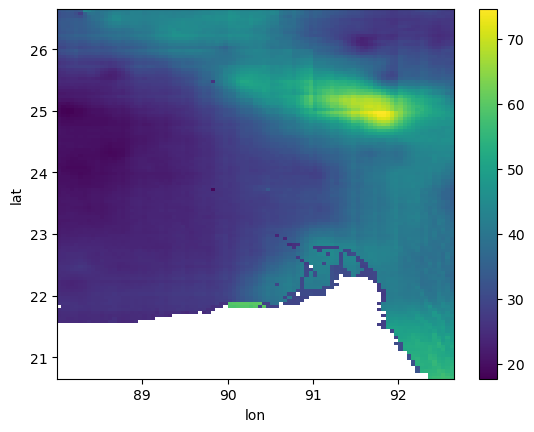

In [143]:
precipxr.mean(dim="time").plot()

In [144]:
# Save as a netcdf for ease of loading in again later
outPath= chirpsPath/'xr'
outPath.mkdir(exist_ok=True)
precipxr.to_netcdf(outPath/'precip.nc')

### Quick plots of monthly climatology

In [147]:
precipMonthlyClim = precipxr.groupby('time.month').mean(dim='time')

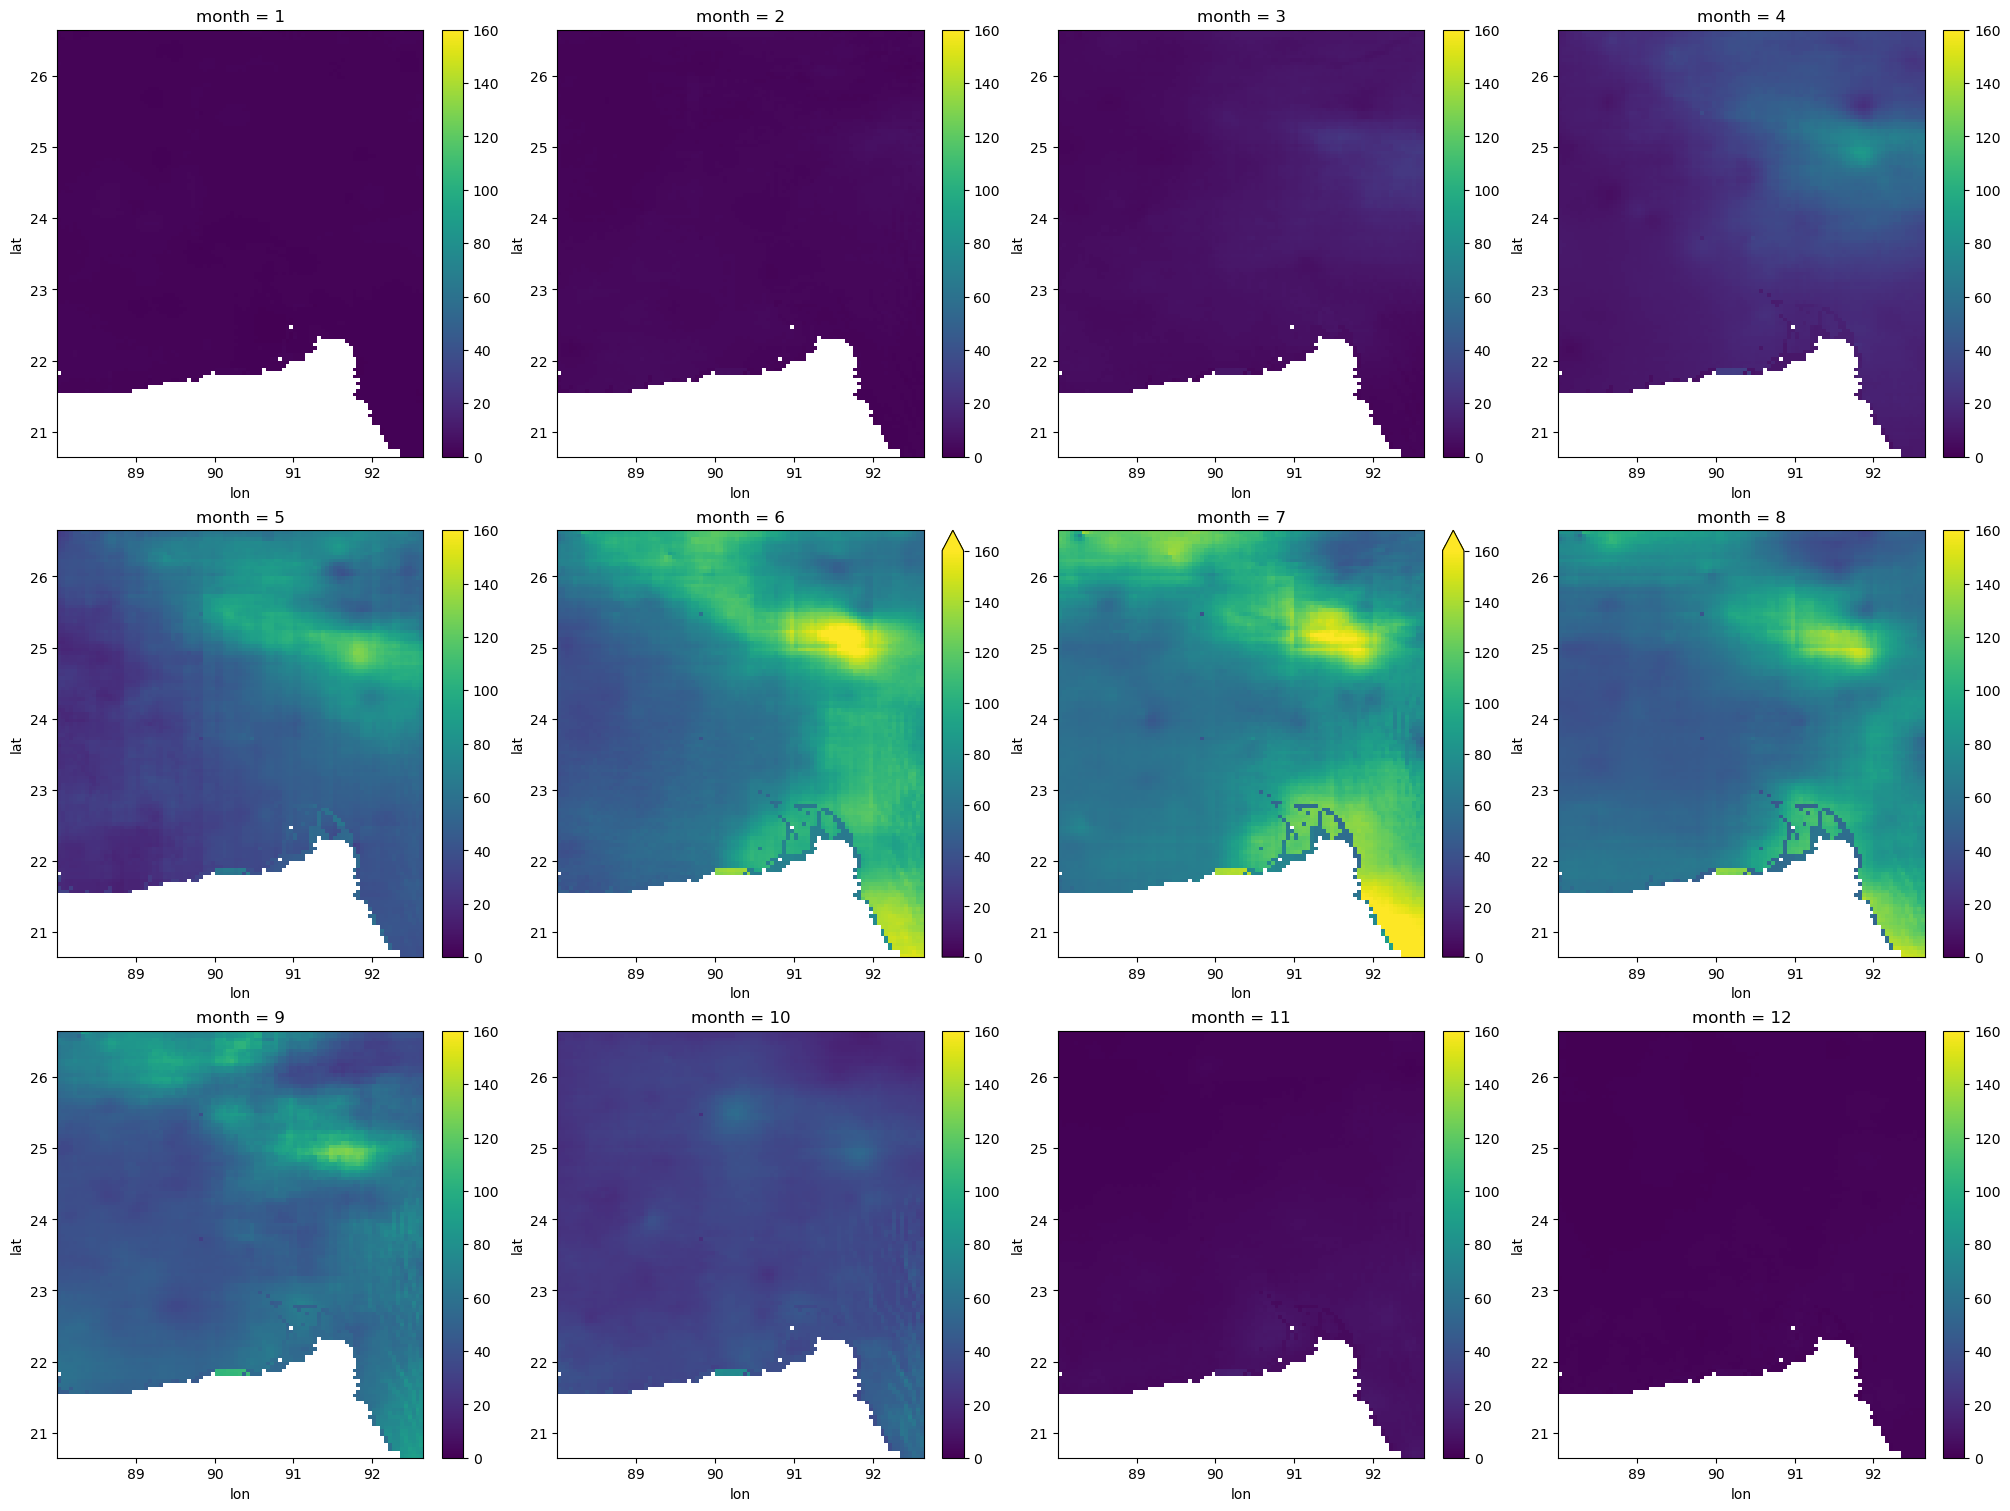

In [153]:
fig, axes = plt.subplots(3,4, figsize=(20,15), constrained_layout=True)

for i, ax in enumerate(axes.ravel()):
    precipMonthlyClim[i,:,:].plot(ax=ax, vmin=0, vmax=160)

## Compute EOF on annual maximum

In [145]:
# Use resample to get annual
precipAnnualMax = precipxr.resample(time='1Y', skipna=True).max(dim='time')

### Quick plots of annual max

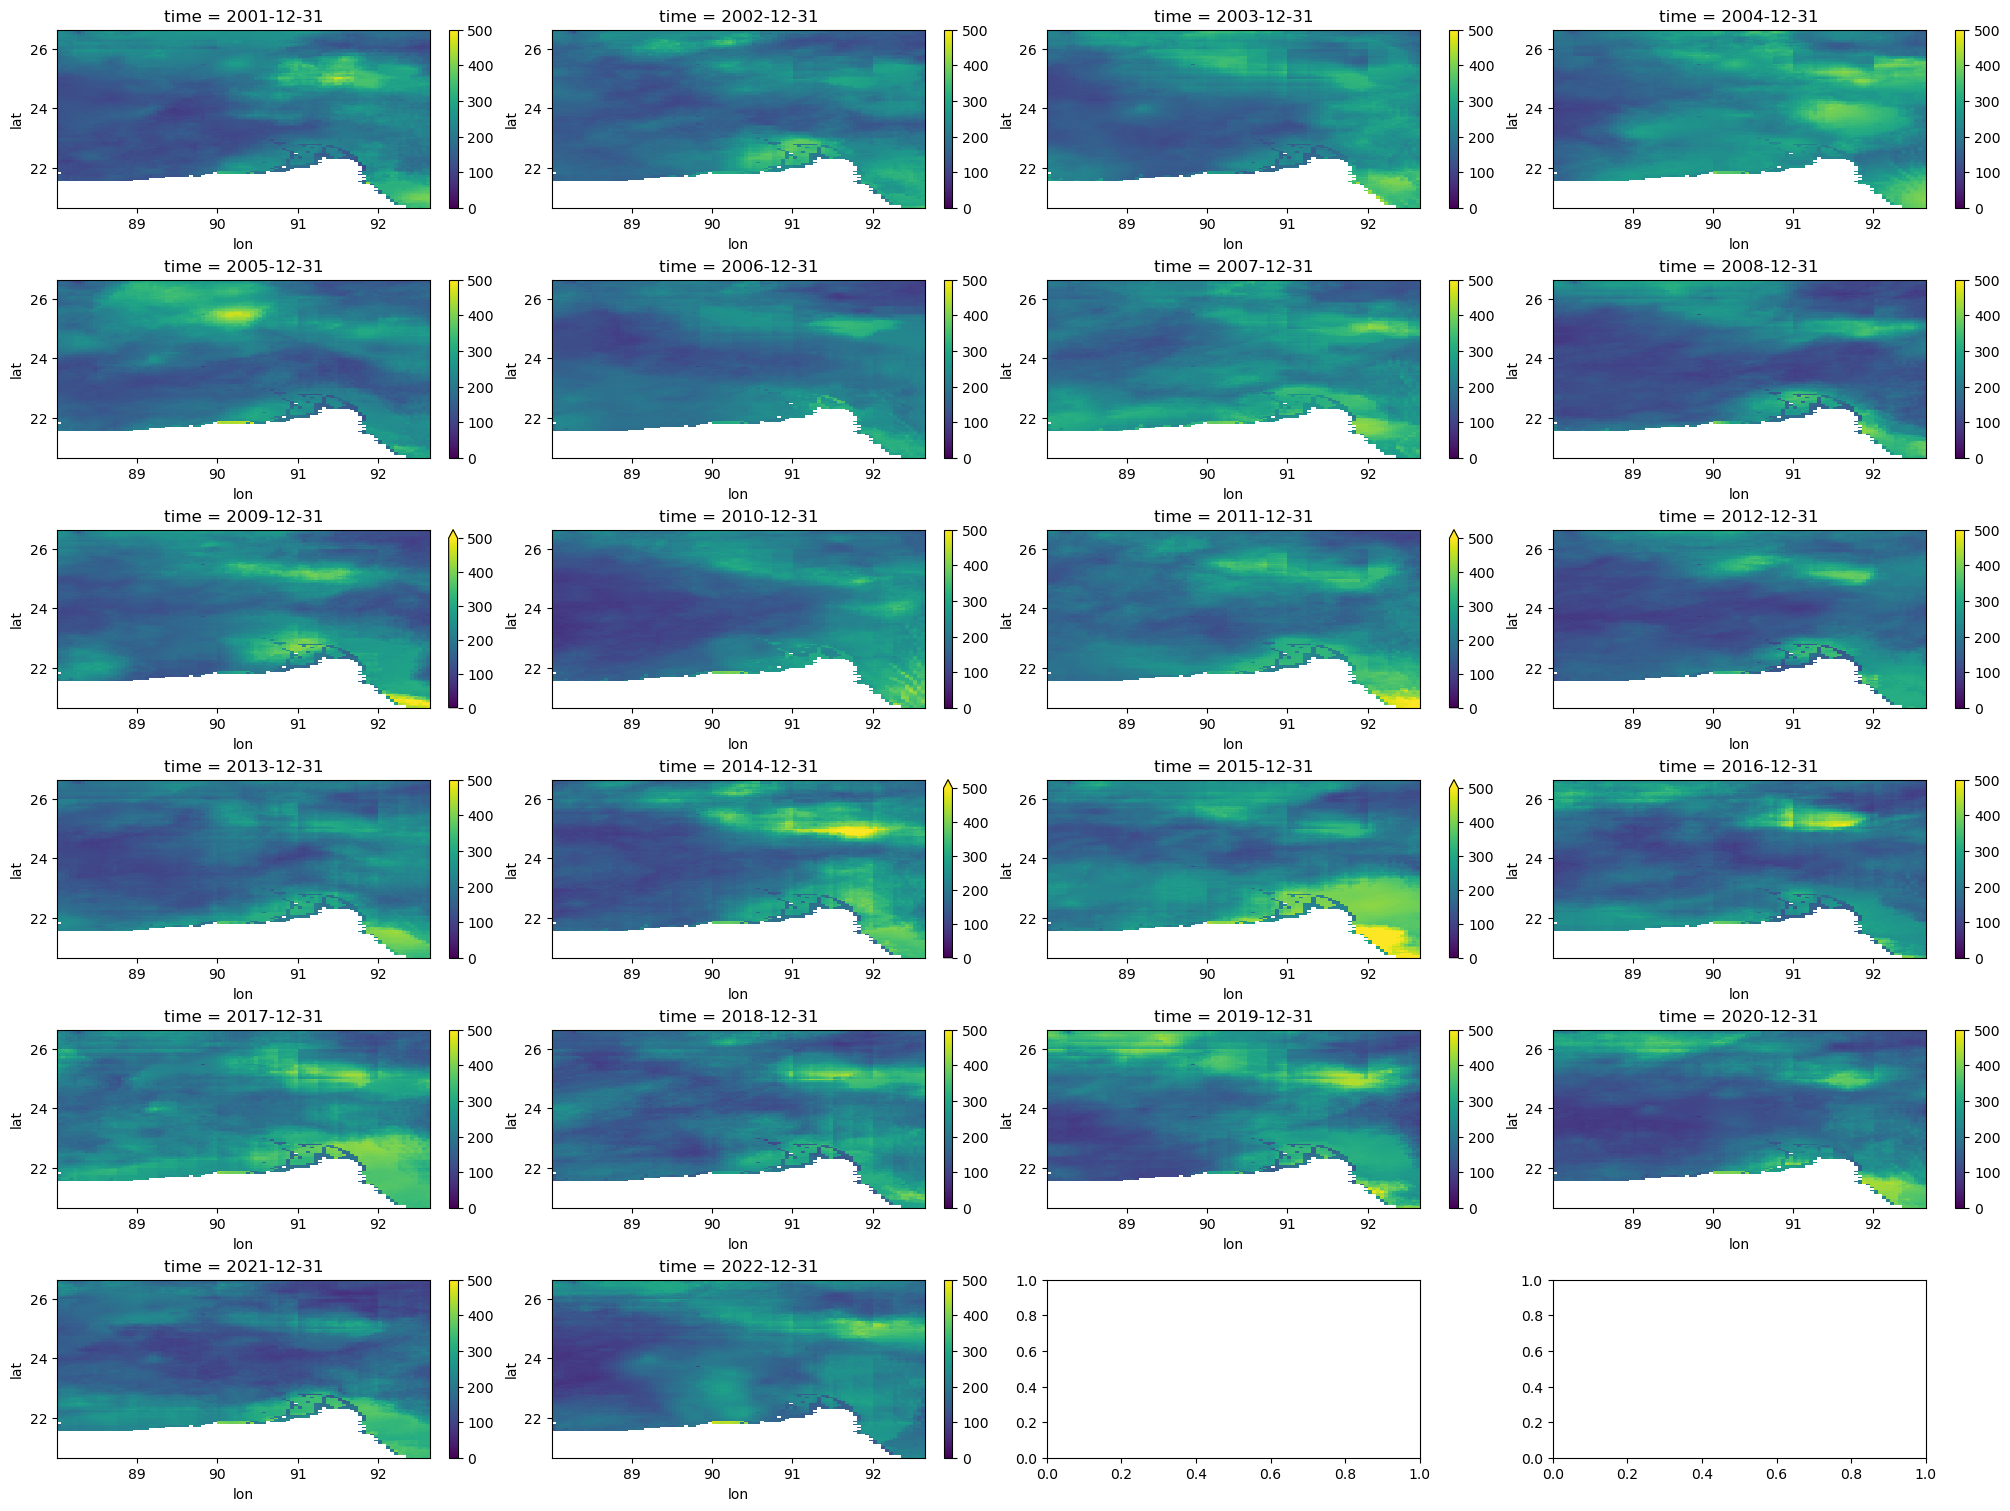

In [156]:
fig, axes = plt.subplots(6,4, figsize=(20,15), constrained_layout=True)

for i, ax in enumerate(axes.ravel()[0:len(precipAnnualMax.time)]):
    precipAnnualMax[i,:,:].plot(ax=ax, vmin=0, vmax=500)

### Reshape and normalize

In [285]:
# Function to reshape, remove locs with missing values
def reshape(data):
    ntime, nrow, ncol = data.shape
    nloc=nrow*ncol
    dataNew = np.array(data).reshape(ntime, nloc)
    print('Shape before removing data with missing vals', dataNew.shape)
    # Remove locs with missing values i.e. only keep pixels which have zero NA values at all timesteps
    noMissing = ~np.isnan(dataNew).any(axis=0)
    dataNew = dataNew[:,noMissing]
    print('Shape before removing data with missing vals', dataNew.shape)
    return dataNew, ntime, nrow, ncol, nloc, noMissing

In [286]:
precipAnnualMax2D, ntime, nrow, ncol, nloc, noMissing = reshape(precipAnnualMax)

Shape before removing data with missing vals (22, 11160)
Shape before removing data with missing vals (22, 9317)


In [287]:
# Function to normalize - subtract mean and divide by standard deviation at each pixel
def normalize(data):
    anom = (data - data.mean(axis=0)) / data.std(axis=0)
    return anom

In [288]:
precipAnnualMaxAnom = normalize(precipAnnualMax2D)

In [289]:
precipAnnualMaxAnom[0,:]

array([ 0.55329358,  0.55739635,  0.49202177, ..., -0.29978521,
       -0.14219201,  0.02005767])

### Perform EOF

In [278]:
# Function to perform EOF
def getEOF(dataAnom, k, nrow, ncol, noMissing):
    U, S, Vt = sp.sparse.linalg.svds(dataAnom, k=k)
    # Sort the eigenmodes
    sort_index = np.argsort(S)[::-1]
    S = S[sort_index]
    U = U[:,sort_index]
    V = Vt.T[:,sort_index]
    # Create the PCs time series
    pcs = dataAnom @ V
    # Create the EOFs with dimensions of the original data
    eofs = np.full((nrow*ncol, S.shape[0]), np.nan) 
    eofs[noMissing,:] = V
    eofs = eofs.reshape([nrow, ncol, S.shape[0]])
    print('EOFs',eofs.shape)
    print('PCs',pcs.shape)
    return eofs, pcs

In [279]:
eofs, pcs = getEOF(precipAnnualMaxAnom, 21, nrow, ncol, noMissing)

EOFs (120, 93, 21)
PCs (22, 21)


In [290]:
# Swap sign of the first EOF
eofs[:,:,0]=-eofs[:,:,0]

### Plot the EOFs

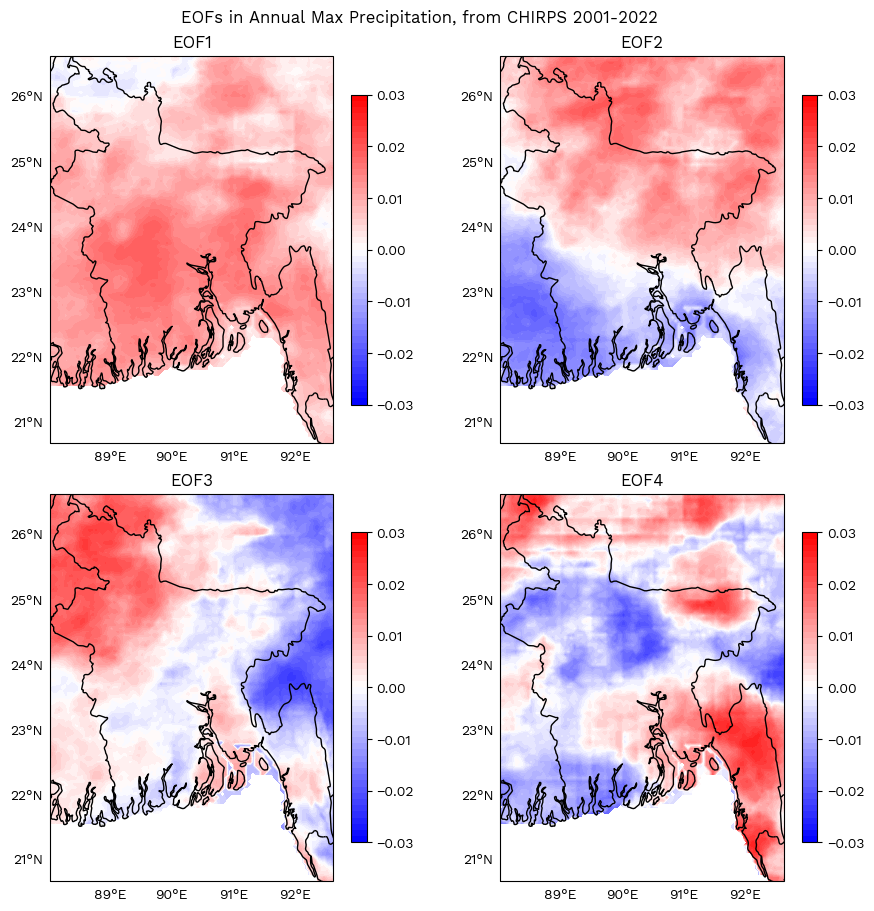

In [291]:
vmin, vmax, nlevels, nlevelsCbar = -0.03, 0.03, 51, 7
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)

fig, axes = plt.subplots(2, 2, figsize=(9,9), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):

    ax.set_title('EOF{0}'.format(i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([precipxr.lon.min().values, precipxr.lon.max().values, precipxr.lat.min().values, precipxr.lat.max().values], crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(precipxr.lon, precipxr.lat, eofs[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar),
                      extend='both', shrink=0.8)

### Plot the PCs

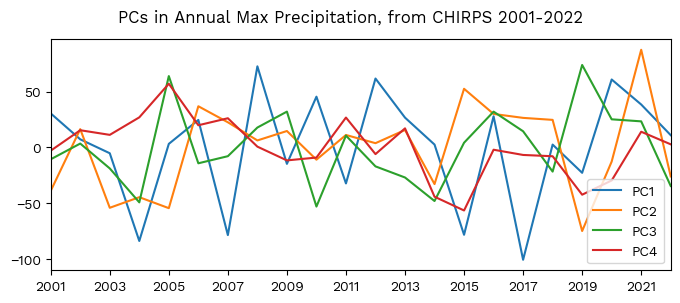

In [259]:
years=[pd.to_datetime(item).year for item in precipAnnualMax.time.values]
fig, ax = plt.subplots(figsize=(8,3))
fig.suptitle('PCs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i in range(4):
    ax.plot(years, pcs[:,i], label='PC{}'.format(i+1))
    
ax.set_xlim(min(years), max(years))
ax.set_xticks(range(min(years), max(years), 2), range(min(years), max(years), 2))
ax.legend()

plt.show()

## Perform rotated EOF

In [271]:
A.shape

(22, 3)

In [273]:
def varimax_rotation(A, reltol=1e-9, itermax=1000, normalize=False):
    # following Lawley and Maxwell (1962)
  
    if normalize: # this is the 'Kaiser normalization', not the pre-normalization we were talking about above
        h = np.sqrt(np.sum(A**2, axis=1))
        A = A / h[:, np.newaxis]

    # get the size of the selected eigenvectors matrix
    nrows, ncol = A.shape
    
    # set the gamma value for varimax
    gamma = 1.0 
    
    # this is the initial rotation matrix, T, which starts simply as the identity matrix
    T = np.eye(ncol) 
    
    # first 'rotation' is just the dot product of the loadings and the identity matrix
    B = np.dot(A, T) 
    
    var_new = 0
    converged = False

    for k in range(1, itermax + 1): # iterations can be up to itermax
        
        # set the prior variance to the previous step
        var_prior = var_new
        
        # svd of the dot product of the unroated EOFs and the variance of the squared loadings of the current REOF 
        U, S, V = np.linalg.svd(np.dot(A.T, (nrows * B**3 - gamma * B @ np.diag(np.sum(B**2, axis=0)))))
        
        # recalculate the rotation matrix as the dot product of the eigenvectors 
        T = np.dot(U, V)
        
        # the new variance metric is the sum of the diagonals of S
        var_new = np.sum(S)
        
        # recalculate the REOFs as the dot product of the EOFs and new rotation matrix
        B = np.dot(A, T)
        
        # if we are now below the relative tolerance, exit and report the values
        if abs(var_new - var_prior) / var_new < reltol:
            break
    
    # Unnormalize the rotated loadings if necessary
    if normalize:
        B = B * h[:, np.newaxis]
    
    return B, T

In [274]:
# set the number of eigenvectors to rotate
numberToRotate = 3 

# create a subset of the eigenvectors and put them in the array called A
A = U[:,0:numberToRotate] 

## EOF pre-scaling

# option 1, no scaling - returns REOFs that are orthogonal but time series will now be correlated - Mestes-Nunez (2000) calls this 'EOF mode'
# A = A

# option 2, multiply by the square root of the eigenvalues - Mestes-Nunez (2000) calls this 'PCA mode' = preserves neither characteristic
A = A * np.sqrt(S[0:numberToRotate])  

# option 3, divide by the square root of the eigenvalues - signals remain uncorrelated - this is 'an unusual case' as Mestes-Nunez (2000) says
# A = A / np.sqrt(S[0:numberToRotate]) 

# run our internal function for varimax rotation on the selected scaled EOFs:
reofs, rotation_matrix = varimax_rotation(A,normalize=True)

### Plot the REOFs

In [275]:
reofs.shape

(22, 3)

In [276]:
eofs.shape

(120, 93, 21)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

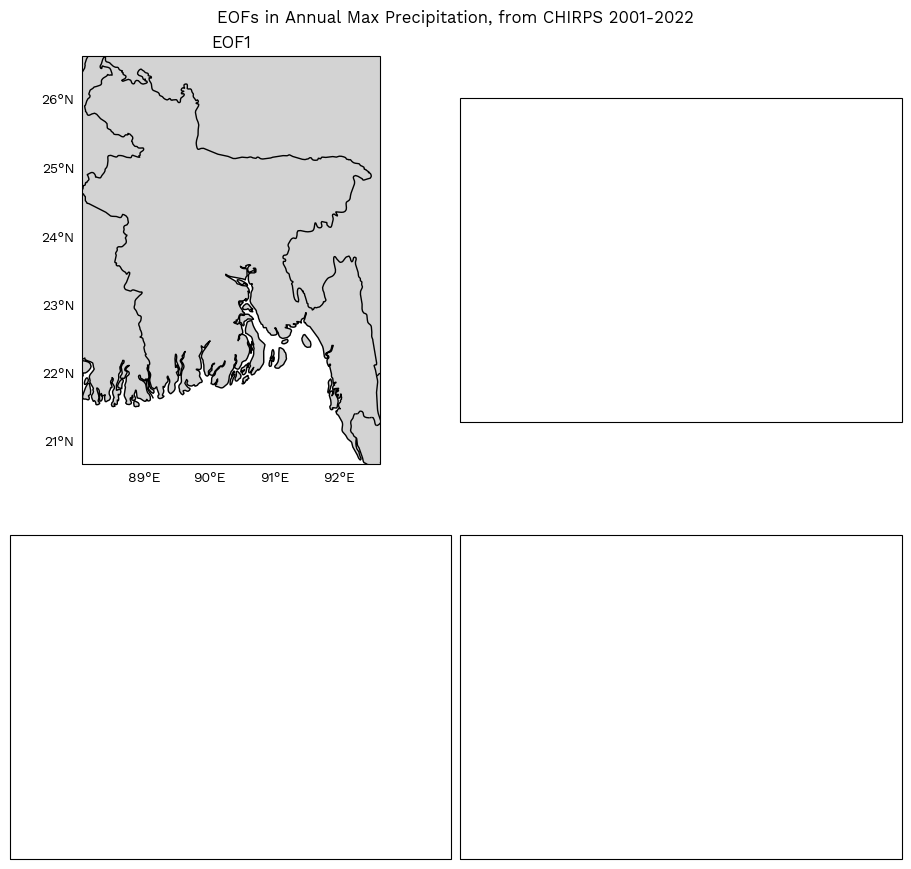

In [268]:
vmin, vmax, nlevels, nlevelsCbar = -0.03, 0.03, 51, 7
cmap='bwr'
levels = np.linspace(vmin, vmax, nlevels)

fig, axes = plt.subplots(2, 2, figsize=(9,9), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):

    ax.set_title('EOF{0}'.format(i+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([precipxr.lon.min().values, precipxr.lon.max().values, precipxr.lat.min().values, precipxr.lat.max().values], crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(precipxr.lon, precipxr.lat, reofs[:,:,i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar),
                      extend='both', shrink=0.8)